In [10]:
#Import necesarry libraries 
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils

In [3]:
# mount drive with google drive
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/BrainTumor_Dataset'  

# Training folder path
Train_path='/content/drive/MyDrive/BrainTumor_Dataset/Training' 

# Testing folder path
Test_path='/content/drive/MyDrive/BrainTumor_Dataset/Testing' 

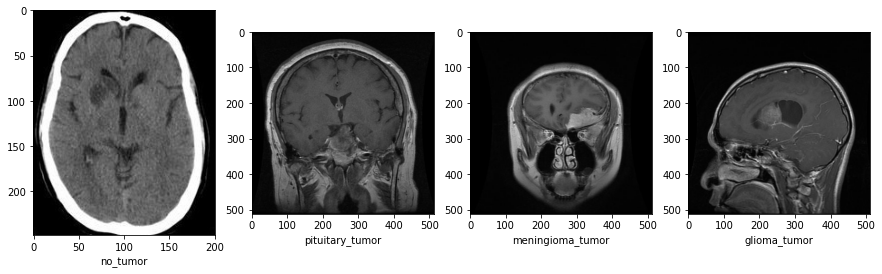

In [5]:
# Show all images from each classes
index=1
plt.figure(figsize=(15,5))
for dir in os.listdir(Train_path):
  label = dir
  for img in os.listdir(os.path.join(Train_path, dir)):
    plt.subplot(1,4, index)
    plt.imshow(cv2.imread(os.path.join(Train_path, dir, img)))
    plt.xlabel(label)
    index = index+ 1
    break

plt.show()

In [8]:
import cv2

In [12]:
# Data preprocessing  and Resize for all images with size of 224 * 224

IMAGE_SIZE = (224, 224)
labels = {0:'glioma_tumor', 1:'meningioma_tumor', 2:'no_tumor', 3:'pituitary_tumor'}
labels_index = {'glioma_tumor':0, 'meningioma_tumor':1, 'no_tumor':2, 'pituitary_tumor':3}

def load_data(path):
    X, y = [], []
    for dir in os.listdir(path):
        label=dir
        for img in tqdm(os.listdir(os.path.join(path, dir))):
            # read image
            image = cv2.imread(os.path.join(path, dir, img)) # Read all images
            image = cv2.resize(image, IMAGE_SIZE) # Resize all images
            X.append(image)
            y.append(labels_index.get(label)) # add numerical labels
    X = np.array(X)
    y = np.array(y)

    # Return numpy array X with shape = (n, 224, 224, 3) & y with shape(n, 1) Reduce the dimension of y
    return X, np.expand_dims(y, -1)

(X_train, y_train), (X_test, y_test) = load_data(Train_path), load_data(Test_path)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

100%|██████████| 105/105 [00:01<00:00, 88.71it/s]


((2870, 224, 224, 3), (2870, 1), (394, 224, 224, 3), (394, 1))

In [6]:
import random

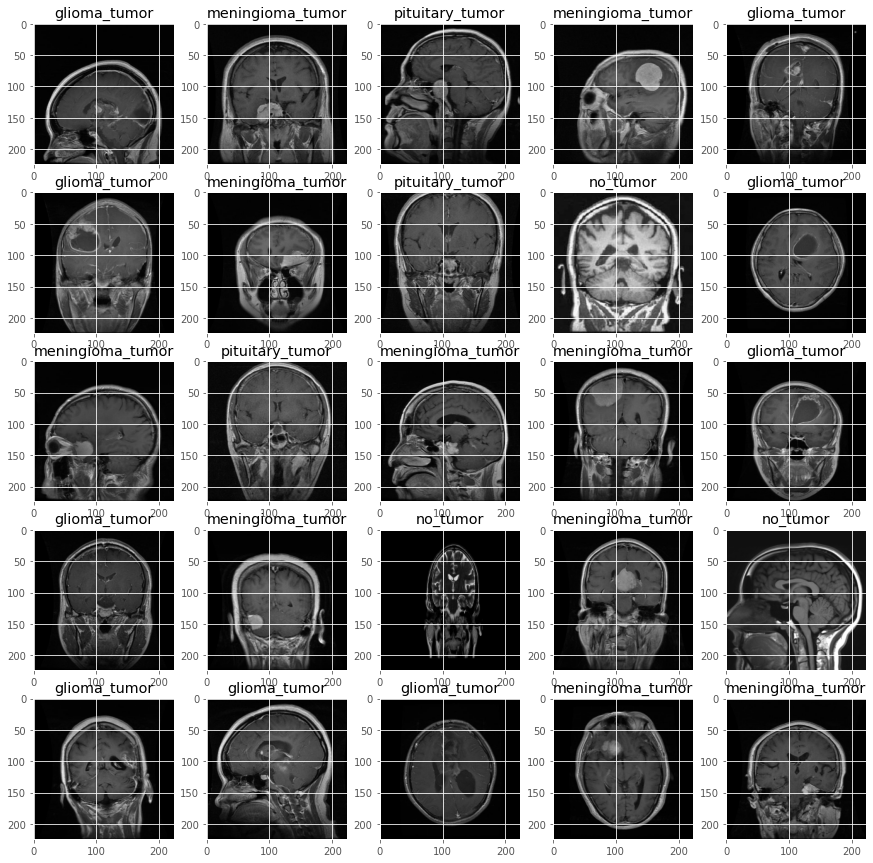

In [39]:
# plot Rendom images from dataset
def plot_data(X, y):
    fig, axis = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

    for ax in axis.flat:
        index = random.randint(0, len(X)-1)
        ax.imshow(X[index])

        label = ''
        if y.shape[1] == 1:
            label = labels.get(y[index][0])
        else:
            label = labels.get(np.argmax(y[index]))

        ax.set_title(label)

plot_data(X_train, y_train)

In [13]:
# Use Image Data Generator

datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory('/content/drive/MyDrive/BrainTumor_Dataset/Training', target_size=(224,224), batch_size=32, class_mode='categorical', subset='training')

valid_data = datagen.flow_from_directory('/content/drive/MyDrive/BrainTumor_Dataset/Training', target_size=(224,224), batch_size=32, class_mode='categorical', subset='validation')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/drive/MyDrive/BrainTumor_Dataset/Testing/', target_size=(224,224), class_mode='categorical')

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [14]:
effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224,224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= effnet.input, outputs=model)

model.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

In [16]:
# Train the model

history = model.fit(train_data, epochs=10, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.7969 - accuracy: 0.6874
Epoch 1: val_accuracy improved from -inf to 0.56195, saving model to model.h5
72/72 [==============================] - 108s 1s/step - loss: 0.7969 - accuracy: 0.6874 - val_loss: 0.9406 - val_accuracy: 0.5620
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.3124 - accuracy: 0.8942
Epoch 2: val_accuracy improved from 0.56195 to 0.81675, saving model to model.h5
72/72 [==============================] - 74s 1s/step - loss: 0.3124 - accuracy: 0.8942 - val_loss: 0.4764 - val_accuracy: 0.8168
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.9299
Epoch 3: val_accuracy improved from 0.81675 to 0.84468, saving model to model.h5
72/72 [==============================] - 73s 1s/step - loss: 0.1983 - accuracy: 0.9299 - val_loss: 0.4053 - val_accuracy: 0.8447
Epoch 4/10
72/72 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.9

In [15]:
# Compile the model

model.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto", verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


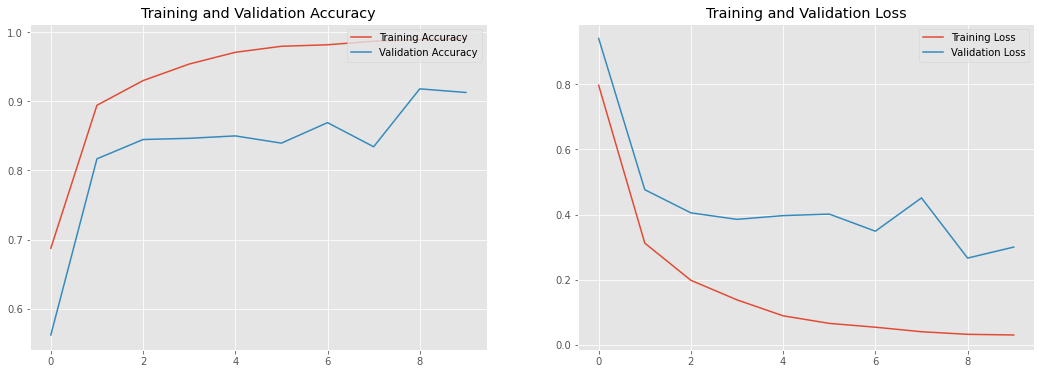

In [18]:
# Plot accuracy and  loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['accuracy'])), acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
from tensorflow.keras.models import load_model
model.save('model_Efficent.h5')

In [23]:
#y_pred = model.predict(test_data)

In [24]:
#import numpy as np
#y_pred = np.argmax(y_pred, axis=1)

In [25]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [26]:
model=load_model('model_Efficent.h5')

In [35]:
test_img=image.load_img('/content/drive/MyDrive/BrainTumor_Dataset/Testing/meningioma_tumor/image(4).jpg',target_size=(224,224))

meningioma_tumor


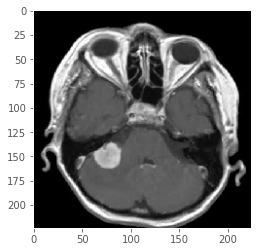

In [38]:
# Obtain Prediction on Test Image

class_dict = {0: "glioma_tumor", 1: "meningioma_tumor", 2: "no_tumor", 3: "pituitary_tumor"}

test_img=image.load_img('/content/drive/MyDrive/BrainTumor_Dataset/Testing/meningioma_tumor/image(4).jpg',target_size=(224,224))

plt.imshow(test_img)

plt.grid(False)

test_img1 = np.expand_dims(test_img, axis=0)

pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class =class_dict[pred]
print(pred_class)